# Subtask2a

In [33]:
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

class DataGenerator(Sequence):
    def __init__(self, data, batch_size, clip_processor, clip_model, data_type, label_binarizer, max_length=77, is_training=True, is_labeled=True):
        self.data = data
        self.batch_size = batch_size
        self.clip_processor = clip_processor
        self.clip_model = clip_model
        self.label_binarizer = label_binarizer
        self.max_length = max_length
        self.indices = np.arange(len(self.data))
        self.is_training = is_training  # New attribute to indicate training mode
        self.is_labeled = is_labeled  # New flag to indicate if data is labeled
        self.image_dir = data_paths[data_type]['image_dir']  # Get image directory based on data_type


    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.data[k] for k in batch_indices]
        
        if self.is_labeled:
            X, y = self.preprocess_data(batch)
            if self.is_training:
                return X, y
            else:
                batch_ids = [sample["id"] for sample in batch]
                return X, y, batch_ids
        else:
            X = self.preprocess_data(batch, labeled=False)
            if not self.is_training:
                batch_ids = [sample["id"] for sample in batch]
            return X, batch_ids 

    def load_image(self, image_path):
        try:
            with Image.open(image_path) as img:
                return img.convert('RGB')
        except IOError:
            print(f"Error in loading image: {image_path}. Using a placeholder image.")
            return Image.new('RGB', (224, 224), color='white')

    def preprocess_data(self, batch, labeled=True):
        texts = [sample["text"] for sample in batch]
        image_filenames = [sample["image"] for sample in batch]
        if labeled and self.label_binarizer:
            labels = [sample.get("labels", []) for sample in batch]
            default_label = ['None']
            labels = [label if label else default_label for label in labels]
            y = self.label_binarizer.transform(labels)
        else:
            y = None
        processed_texts = self.clip_processor(text=[text[:self.max_length] for text in texts], return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.clip_model.device) for k, v in processed_texts.items()}
        text_embeddings = self.clip_model.get_text_features(**inputs).cpu().detach().numpy()

        images = [self.load_image(os.path.join(self.image_dir, filename)) for filename in image_filenames]
        processed_images = self.clip_processor(images=images, return_tensors="pt")
        image_embeddings = self.clip_model.get_image_features(**processed_images).cpu().detach().numpy()
        combined_embeddings = np.concatenate((text_embeddings, image_embeddings), axis=1)
        
        if labeled:
            return combined_embeddings, y
        else:
            return combined_embeddings

    def on_epoch_end(self):
        np.random.shuffle(self.indices) 
        
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)


    
class MultiMemeClassification:
    def __init__(self, label_tree, data_paths):
        self.label_tree = label_tree
        self.label_binarizer = MultiLabelBinarizer()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.model = None
        self.data_paths = data_paths  #dictionary for data paths by type

    def load_and_preprocess_data(self, data_type, sample_size=None):
        #select the file and image paths based on the data_type
        data_info = self.data_paths.get(data_type)
        if not data_info:
            raise ValueError(f"Invalid data type: {data_type}")

        json_file_path = data_info.get('json_path')
        image_dir = data_info.get('image_dir')

        # load JSON data
        with open(json_file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        #check if image files exist
        for sample in data:
            image_path = os.path.join(image_dir, sample.get("image", ""))
            if not os.path.exists(image_path):
                print(f"Warning: Image file not found at {image_path}")

        if sample_size:
            data = np.random.choice(data, sample_size, replace=False)

        #handling labels differently based on data_type
        if data_type == 'test':
            #for 'test' data, labels may not be present
            labels = [sample.get("labels", None) for sample in data]
            #keep only samples with labels (filter out None)
            labels = [label for label in labels if label is not None]
        else:
            #for 'train' and 'dev' data, assign a default label if none exist
            default_label = ['None']
            labels = [sample.get("labels", []) for sample in data]
            labels = [label if label else default_label for label in labels]

        self.label_binarizer.fit(labels)

        return data

    
    def explore_data(self, sample_size=None, data_type='train', examples_to_show=2):
        data = self.load_and_preprocess_data(data_type, sample_size)

        print(f"Total number of samples: {len(data)}")
        print(f"Total number of unique labels: {len(self.label_binarizer.classes_)}")
        print("Unique labels:", self.label_binarizer.classes_)

        data_generator = DataGenerator(data, batch_size=1, clip_processor=self.clip_processor, clip_model=self.clip_model, label_binarizer=self.label_binarizer, data_type=data_type)

        for i in range(examples_to_show):
            sample = [data[i]]  # Wrap the single sample in a list
            combined_embeddings, _ = data_generator.preprocess_data(sample, labeled=True)

            print(f"\nSample {i+1}:")
            print("Text:", sample[0]["text"])
            print("Image:", sample[0]["image"])
            print("Combined Embedding Shape:", combined_embeddings.shape)
            print("Combined Embedding:", combined_embeddings)
            
    def build_model(self, num_classes, embedding_size=1024, dropout_rate=0.5, learning_rate=0.005):
        input_layer = Input(shape=(embedding_size,), dtype='float32', name="input")
        dense_layer = Dense(1024, activation='relu')(input_layer)
        dropout_layer = Dropout(dropout_rate)(dense_layer)
        output_layer = Dense(num_classes, activation='sigmoid')(dense_layer)

        self.model = Model(inputs=input_layer, outputs=output_layer)
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        return self.model

    
    def train_model(self, save_model_path, batch_size=32, epochs=5, data_type='train', validation_size=0.2, learning_rate=0.01, random_state=42, sample_size=None):
        data = self.load_and_preprocess_data(data_type, sample_size)

        #split data into training and validation sets
        X_train_indices, X_val_indices = train_test_split(
            range(len(data)), test_size=validation_size, random_state=random_state
        )

        #generate training and validation data using indices
        train_data = [data[i] for i in X_train_indices]
        val_data = [data[i] for i in X_val_indices]

        #initialize data generators
        train_generator = DataGenerator(train_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=True)
        val_generator = DataGenerator(val_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=True,)

        #build  the model
        self.build_model(num_classes=len(self.label_binarizer.classes_), dropout_rate=0.05, learning_rate=learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

        #train the model
        history = self.model.fit(
            train_generator, epochs=epochs, validation_data=val_generator, callbacks=[early_stopping]
        )

        #save model
        self.model.save_weights(save_model_path)
        print(f"Model saved at {save_model_path}")

        return history
   
    def plot_training_history(self, history):
        plt.figure(figsize=(10, 4))
        
        #plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        #plot loss 
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.show()      

    def calculate_hierarchy_distance(self, node1, node2):
        def find_path(tree, node, path=[]):
            if node in tree:
                return path + [node]
            for k, v in tree.items():
                if isinstance(v, dict):
                    new_path = find_path(v, node, path + [k])
                    if new_path:
                        return new_path
            return []

        node1_tuple = (node1,) if isinstance(node1, str) else node1
        node2_tuple = (node2,) if isinstance(node2, str) else node2

        path1 = find_path(self.label_tree, node1_tuple)
        path2 = find_path(self.label_tree, node2_tuple)

        common_length = len(set(path1) & set(path2))
        distance = len(path1) + len(path2) - 2 * common_length
        return distance
    

    def evaluate_model(self, batch_size, save_model_path, num_classes, output_json_path, data_type='dev',learning_rate=0.005):
        # Load and preprocess test data
        dev_data = self.load_and_preprocess_data(data_type)
        test_generator = DataGenerator(dev_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=False)

        # Build the model and load saved weights
        self.build_model(num_classes=len(self.label_binarizer.classes_), dropout_rate=0.5, learning_rate=learning_rate)
        self.model.load_weights(save_model_path)

        #initialize variables for metrics calculation
        total_precision = 0
        total_recall = 0
        total_samples = 0
        true_labels_all = []
        predicted_labels_all = []

        #initialize MultiLabelBinarizer
        mlb = MultiLabelBinarizer(classes=self.label_binarizer.classes_)
        mlb.fit([self.label_binarizer.classes_])

        results = []  # List to store results

        #iterate over batches in the test generator
        for X, y_true, batch_ids in test_generator:
            y_pred = self.model.predict(X)

            #iterate over predictions in the batch
            for sample_id, prediction, true_label in zip(batch_ids, y_pred, y_true):
                gold_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if true_label[j] == 1]
                predicted_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if prediction[j] > 0.5]
                prediction_list = prediction.tolist()

                label_probabilities = {label: float(prob) for label, prob in zip(self.label_binarizer.classes_, prediction_list)}

                true_labels_all.append(gold_labels)
                predicted_labels_all.append(predicted_labels)

                results.append({
                    'id': sample_id,
                    'ture_labels': gold_labels,
                    'predicted_labels': predicted_labels,
                    'predicted_probabilities': label_probabilities  # Convert numpy array to list
                    
                })
                
                #hierarchical evaluation
                for predicted_label in predicted_labels:
                    if predicted_label in gold_labels:
                        total_precision += 1
                        total_recall += 1
                    else:
                        for gold_label in gold_labels:
                            distance = self.calculate_hierarchy_distance(predicted_label, gold_label)
                            if distance is not None and distance > 0:
                                total_precision += 0.5
                                total_recall += 0.5

                total_samples += 1

        #aggregate metrics over all samples
        average_precision = total_precision / total_samples if total_samples > 0 else 0
        average_recall = total_recall / total_samples if total_samples > 0 else 0
        hierarchical_f1 = 2 * (average_precision * average_recall) / (average_precision + average_recall) if (average_precision + average_recall) != 0 else 0

        true_labels_all_binary = mlb.transform(true_labels_all)
        predicted_labels_all_binary = mlb.transform(predicted_labels_all)
        target_names = self.label_binarizer.classes_
        
        print("Classification Report:")
        print(classification_report(true_labels_all_binary, predicted_labels_all_binary, target_names=target_names))
        
        result_file_name = f"subtask2a_dev_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(results, json_file, indent=4)
            
        return hierarchical_f1


    def test_model(self, batch_size, save_model_path, output_json_path, data_type='test', learning_rate=0.001):
        test_data = self.load_and_preprocess_data(data_type)
        test_generator = DataGenerator(test_data, batch_size, self.clip_processor, self.clip_model, data_type, self.label_binarizer, is_training=False, is_labeled=False)

        # Load the trained model weights
        self.build_model(num_classes=23, dropout_rate=0.5, learning_rate=learning_rate)
        self.model.load_weights(save_model_path)

        predictions = []

        # Iterate over batches in the test generator
        for X, batch_ids in test_generator:
            y_pred = self.model.predict(X)
            print("Raw predictions:", y_pred)
            # Iterate over predictions in the batch
            for sample_id, prediction in zip(batch_ids, y_pred):
                predicted_labels = [self.label_binarizer.classes_[j] for j in range(len(self.label_binarizer.classes_)) if prediction[j] > 0.001]
                prediction_list = prediction.tolist()

                label_probabilities = {label: float(prob) for label, prob in zip(self.label_binarizer.classes_, prediction_list)}
                
                predictions.append({
                    'id': sample_id,
                    'predicted_labels': predicted_labels,
                    'predicted_probabilities': label_probabilities
                })
                
        result_file_name = "subtask2a_test_pred.json"
        destination_path = os.path.join(output_json_path, result_file_name)
        os.makedirs(output_json_path, exist_ok=True)
        with open(destination_path, 'w') as json_file:
            json.dump(predictions, json_file, indent=4)
            
        return "Predictions completed."


#hierarchical tree
#the assigned number are hypothetically
label_tree = {
    'Persuasion': {
        'Pathos': {
            'Appeal to Emotion(visual)': 1,
            'Exaggeration/Minimisation': 2,
            'Loaded Language': 3,
            'Flag waving': 4,
            'Appeal to fear/prejudice': 5,
            'Transfer': 6
        },
        'Ethos': {
            'Transfer': 6,
            'Glittering generalities': 7,
            'Appeal to authority': 8,
            'Bandwagon': 9,
            'Ad Hominem': {
                'Name calling/Labelling': 10,
                'Doubt': 11,
                'Smears': 12,
                'Reduction and Hitlerium': 13,
                'Whataboutism': 14
            }
        },
        'Logos': {
            'Repetition': 15,
            'Obfuscation, Intentional vagueness, Confusion': 16,
            'Justification': {
                'Flag waving': 4,
                'Appeal to fear/prejudice': 5,
                'Appeal to Authority': 8,
                'Bandwagon': 9,
                'Slogans': 17
            },
            'Reasoning': {
                'Distraction': {
                    'Whataboutism': 14,
                    'Presenting Irrelevant Data (Red Herring)': 18,
                    'Straw Man': 19
                },
                'Simplification': {
                    'Black-and-white Fallacy/Dictatorship': 20,
                    'Casual Oversimplification': 21,
                    'Thought-terminating cliché': 22
                }
            }
        },
        'None': 23 # a label for empty samples
    }
}

batch_size = 64
num_classes = 23
output_json_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels'
save_model_path = '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/CLIP_model_weights'

data_paths = {
    'train': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/merged_file.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/merged_images'

    },
    'dev': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/dev_gold_labels/dev_subtask2a_en.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/subtask2a_images/dev_images'
    },
    'test': {
        'json_path': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/english/en_subtask2a_test_unlabeled.json',
        'image_dir': '/Users/jamessmith/Desktop/Desktop/SemEval_Task/data/test_data/test_images/subtask1_2a/english'
    }
}

CLIP_meme_classifier2a = MultiMemeClassification(label_tree, data_paths)


In [34]:
#explore the data
CLIP_meme_classifier2a.explore_data(data_type='train', 
                                    examples_to_show=2
                                   )

Total number of samples: 7500
Total number of unique labels: 23
Unique labels: ['Appeal to (Strong) Emotions' 'Appeal to authority'
 'Appeal to fear/prejudice' 'Bandwagon'
 'Black-and-white Fallacy/Dictatorship' 'Causal Oversimplification'
 'Doubt' 'Exaggeration/Minimisation' 'Flag-waving'
 'Glittering generalities (Virtue)' 'Loaded Language'
 "Misrepresentation of Someone's Position (Straw Man)"
 'Name calling/Labeling' 'None'
 'Obfuscation, Intentional vagueness, Confusion'
 'Presenting Irrelevant Data (Red Herring)' 'Reductio ad hitlerum'
 'Repetition' 'Slogans' 'Smears' 'Thought-terminating cliché' 'Transfer'
 'Whataboutism']

Sample 1:
Text: This is why we're free\n\nThis is why we're safe\n
Image: prop_meme_556.png
Combined Embedding Shape: (1, 1024)
Combined Embedding: [[ 0.23967108  0.11515654 -0.20052052 ... -0.6260278  -0.4458599
   0.36731935]]

Sample 2:
Text: THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ALL TIMES
Image: prop_meme_4839.png
Combined Embedding Shape: (1, 102

In [35]:
history= CLIP_meme_classifier2a.train_model(save_model_path, 
                                          batch_size=32, 
                                          epochs=15,
                                          learning_rate=0.0001,
                                          data_type='train'
                                         )


Epoch 1/15


188/188 [==============================] - 520s 3s/step - loss: 0.2901 - accuracy: 0.2218 - val_loss: 0.2365 - val_accuracy: 0.3000
Epoch 2/15
188/188 [==============================] - 486s 3s/step - loss: 0.2222 - accuracy: 0.3175 - val_loss: 0.2224 - val_accuracy: 0.3207
Epoch 3/15
188/188 [==============================] - 499s 3s/step - loss: 0.2076 - accuracy: 0.3407 - val_loss: 0.2165 - val_accuracy: 0.3347
Epoch 4/15
188/188 [==============================] - 483s 3s/step - loss: 0.1973 - accuracy: 0.3592 - val_loss: 0.2133 - val_accuracy: 0.3433
Epoch 5/15
188/188 [==============================] - 487s 3s/step - loss: 0.1895 - accuracy: 0.3682 - val_loss: 0.2120 - val_accuracy: 0.3560
Epoch 6/15
188/188 [==============================] - 483s 3s/step - loss: 0.1826 - accuracy: 0.3810 - val_loss: 0.2104 - val_accuracy: 0.3520
Epoch 7/15
188/188 [==============================] - 462s 2s/step - loss: 0.1765 - accuracy: 0.3900 - val_loss: 0.2105 - val_accuracy: 0.3440
Epoch 8/15

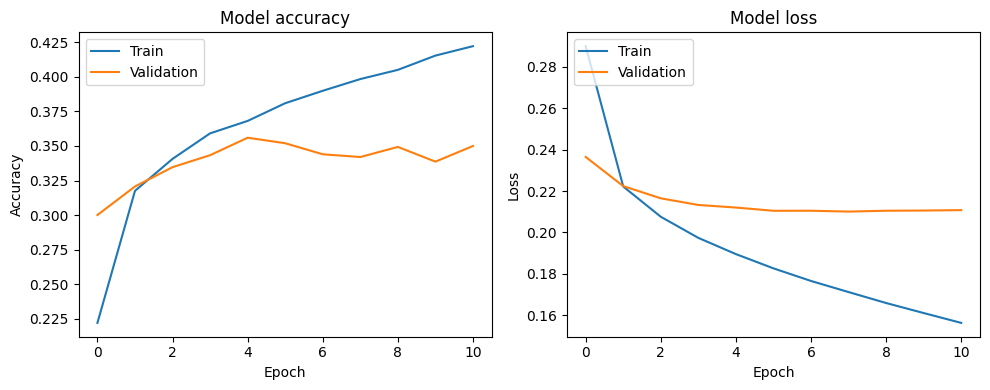

In [36]:
#plot the training history
CLIP_meme_classifier2a.plot_training_history(history)

In [37]:
#evaluate the model using the dev data
hierarchical_f1 = CLIP_meme_classifier2a.evaluate_model(batch_size, 
                                                      save_model_path, 
                                                      num_classes, 
                                                      output_json_path, 
                                                      data_type='dev'
                                                     )
print(f"Average Hierarchical F1: {hierarchical_f1}")


Error in loading image: /Users/jamessmith/Desktop/Desktop/SemEval_Task/data/subtask2a/subtask2a_images/dev_images/prop_meme_144.png. Using a placeholder image.
2/2 [==============================] - 0s 3ms/step
Classification Report:
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.48      0.21      0.30        56
                                Appeal to authority       0.76      0.72      0.74       143
                           Appeal to fear/prejudice       1.00      0.01      0.03        78
                                          Bandwagon       0.00      0.00      0.00        18
               Black-and-white Fallacy/Dictatorship       0.55      0.11      0.18       103
                          Causal Oversimplification       0.00      0.00      0.00        56
                                              Doubt       0.50      0.08      0.13        52
                     

/Users/jamessmith/Desktop/Desktop/python/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jamessmith/Desktop/Desktop/python/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
#get predictions on the unlabeled test data
CLIP_meme_classifier2a.test_model(batch_size, 
                                save_model_path, 
                                output_json_path,
                                data_type='test'
                               )

2/2 [==============================] - 0s 3ms/step
Raw predictions: [[0.00938114 0.00361747 0.00880828 ... 0.13411589 0.7607224  0.01126877]
 [0.26071858 0.02414031 0.02834822 ... 0.06677565 0.07085055 0.01033124]
 [0.00676722 0.6130777  0.07027098 ... 0.0252849  0.07704791 0.01288173]
 ...
 [0.08054186 0.0415182  0.0935787  ... 0.16198389 0.19941318 0.01361134]
 [0.01161732 0.04038189 0.2531858  ... 0.07167596 0.01199445 0.01510048]
 [0.00350425 0.17944863 0.06489912 ... 0.05711488 0.29883063 0.04779452]]
2/2 [==============================] - 0s 4ms/step
Raw predictions: [[2.9441362e-02 1.6283077e-03 2.7742961e-02 ... 1.0046614e-01
  6.7604780e-01 1.9111000e-02]
 [1.4690923e-03 5.8249768e-02 2.9902818e-02 ... 1.7669095e-02
  1.1089793e-01 9.3486719e-03]
 [2.1990300e-03 2.6263688e-03 8.2954885e-03 ... 3.1851858e-02
  1.9289009e-01 5.3292247e-03]
 ...
 [5.2600712e-02 6.1649457e-04 2.9405760e-02 ... 2.4011986e-02
  6.2503648e-01 8.6819097e-02]
 [5.2147377e-03 2.3321030e-03 3.2892272e-02

'Predictions completed.'